In [179]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("swoyam2609/fresh-and-stale-classification")

print("Path to dataset files:", path)

Path to dataset files: /home/sugeng/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1


In [180]:
import os
import shutil
import numpy as np

# Define the path to the dataset
path = '/home/sugeng/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1/dataset'

In [181]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define the ImageDataGenerator
train_ds = image_dataset_from_directory(
    path+'/Train',
    validation_split=0.2,
    label_mode='categorical',
    subset="training",
    color_mode='rgb',
    seed=1337,
    image_size=(224, 224),
    shuffle=True,
    batch_size=32,
)
val_ds = image_dataset_from_directory(
    path+'/Train',
    validation_split=0.2,
    label_mode='categorical',
    subset="validation",
    color_mode='rgb',
    seed=1337,
    shuffle=True,
    image_size=(224, 224),
    batch_size=32,
)

Found 23618 files belonging to 2 classes.
Using 18895 files for training.
Found 23618 files belonging to 2 classes.
Using 4723 files for validation.


In [182]:
'''
Data preprocessing 
- Rescale the pixel values to the [0, 1] range
- Standardize the data
- Enhancing  contrast and brightness
- Higher saturation
- Data augmentation
'''

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Resizing
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.layers import RandomBrightness
# from tensorflow.image import random_saturation
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomFlip

data_augmentation = Sequential([
    RandomContrast(0.2),
    RandomBrightness(0.2),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomFlip('horizontal'),
])

# Create the model
model = Sequential([
    data_augmentation,
    Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')
])


In [183]:
label = ['Fresh', 'Stale']

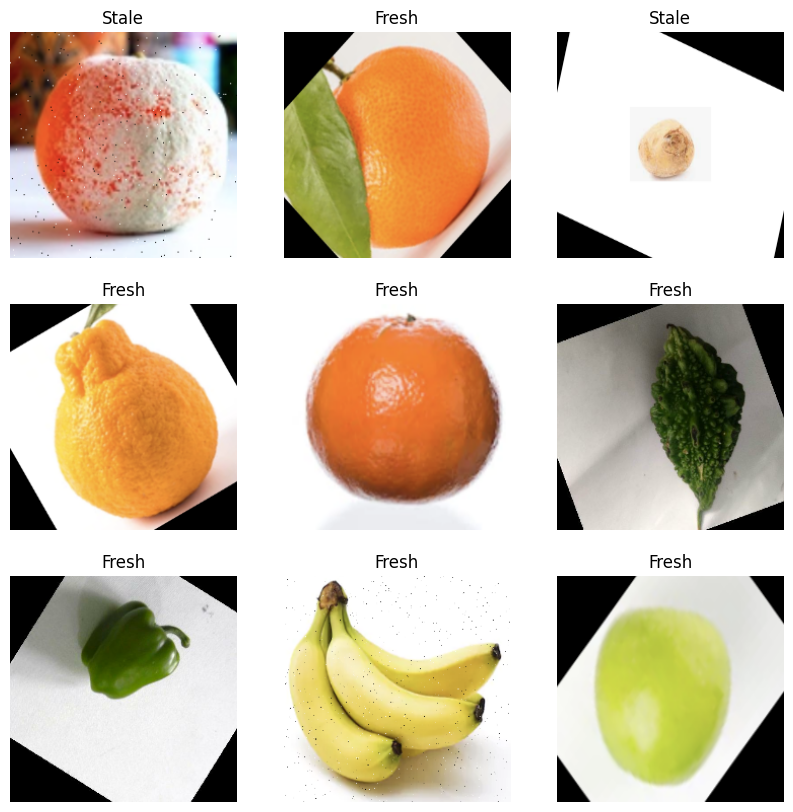

In [184]:
# Plot the first 9 images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(label[np.argmax(labels[i])])
        plt.axis("off")
        
plt.show()

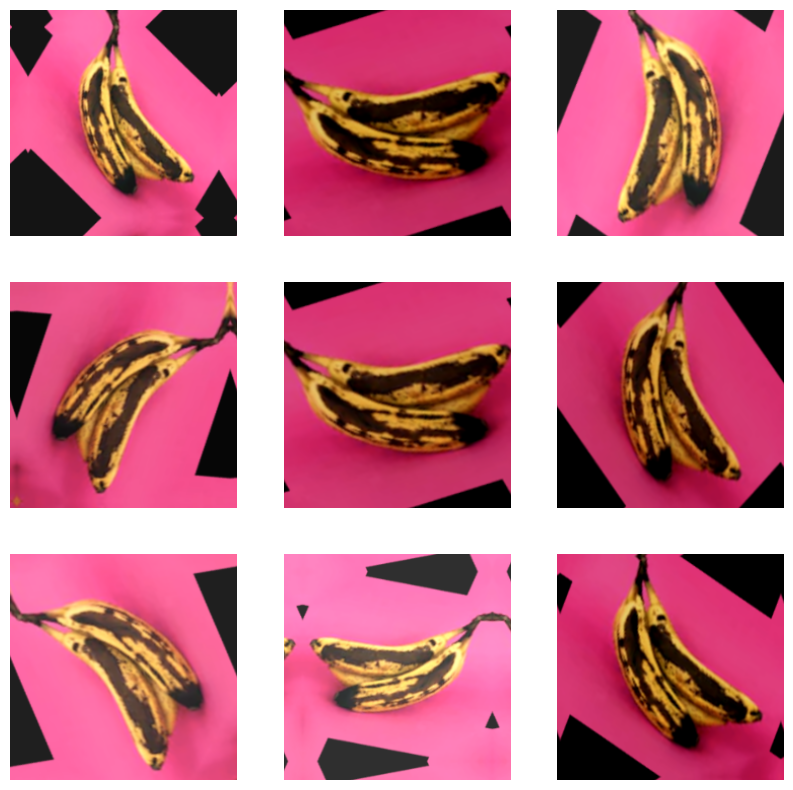

In [200]:
# Plot augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()

In [185]:
# import pretrained model (resnet50)
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = ResNet50(weights='imagenet', include_top=False)
# Add data augmentation layer
model = Sequential([
    data_augmentation,
    Rescaling(1./255),
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax')
])

In [186]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model with early stopping
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

history = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[early_stop])


Epoch 1/30
591/591 ━━━━━━━━━━━━━━━━━━━━ 69s 93ms/step - AUC: 0.8809 - Precision: 0.8138 - Recall: 0.8138 - accuracy: 0.8138 - loss: 0.4984 - val_AUC: 0.4695 - val_Precision: 0.4679 - val_Recall: 0.4679 - val_accuracy: 0.4679 - val_loss: 0.7809
Epoch 2/30
591/591 ━━━━━━━━━━━━━━━━━━━━ 53s 90ms/step - AUC: 0.9581 - Precision: 0.8944 - Recall: 0.8944 - accuracy: 0.8944 - loss: 0.2615 - val_AUC: 0.7738 - val_Precision: 0.7313 - val_Recall: 0.7313 - val_accuracy: 0.7313 - val_loss: 1.8300
Epoch 3/30
591/591 ━━━━━━━━━━━━━━━━━━━━ 54s 90ms/step - AUC: 0.9733 - Precision: 0.9183 - Recall: 0.9183 - accuracy: 0.9183 - loss: 0.2077 - val_AUC: 0.9804 - val_Precision: 0.9346 - val_Recall: 0.9346 - val_accuracy: 0.9346 - val_loss: 0.1749
Epoch 4/30
591/591 ━━━━━━━━━━━━━━━━━━━━ 53s 90ms/step - AUC: 0.9776 - Precision: 0.9241 - Recall: 0.9241 - accuracy: 0.9241 - loss: 0.1903 - val_AUC: 0.9618 - val_Precision: 0.8927 - val_Recall: 0.8927 - val_accuracy: 0.8927 - val_loss: 0.2641
Epoch 5/30
591/591 ━━━━━

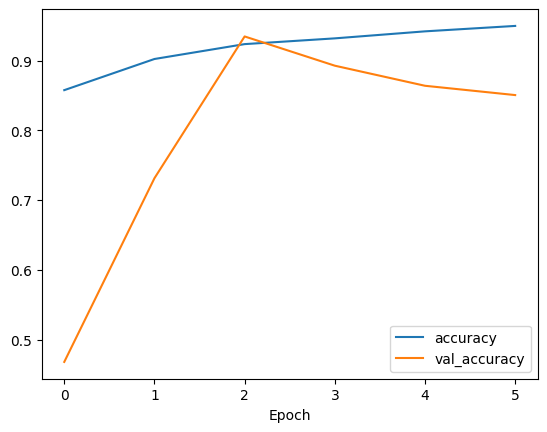

In [187]:
# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()

In [188]:
# save model 
model.save('model.h5')

TypeError: cannot pickle 'module' object

Found 6738 files belonging to 2 classes.
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step


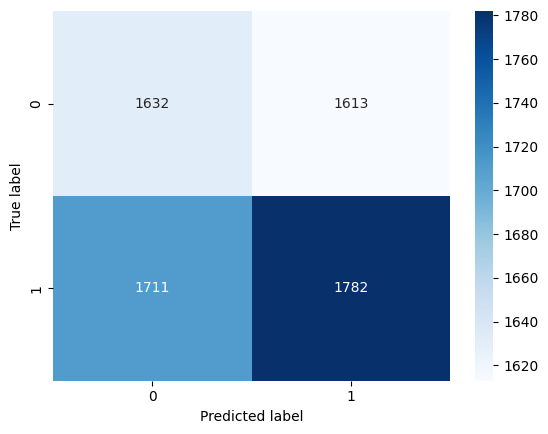

In [189]:
# plot confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn
import pandas

test_ds = image_dataset_from_directory(
    path+'/Test',
    label_mode='categorical',
    color_mode='rgb',
    seed=1337,
    image_size=(224, 224),
    batch_size=32,
)

# Get the true classes
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)  # Convert y_true to binary format
# Get the predicted classes
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()



In [190]:
# Evaluate the model
model.evaluate(test_ds)

211/211 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - AUC: 0.9785 - Precision: 0.9247 - Recall: 0.9247 - accuracy: 0.9247 - loss: 0.1871


[0.192625492811203,
 0.9254971742630005,
 0.9769343137741089,
 0.9254971742630005,
 0.9254971742630005]

In [194]:
# pred single image
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = '/home/sugeng/Downloads/test2.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)
print('Fresh : ', predictions[0][0].astype(float))
print('Stale : ', predictions[0][1].astype(float))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Fresh :  0.14595824480056763
Stale :  0.8540417551994324


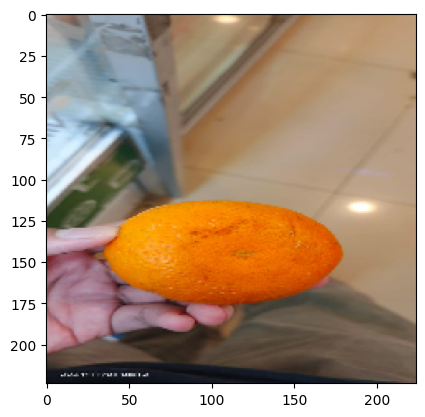

In [195]:
# plot the image
plt.imshow(img)
plt.show()


In [196]:
import tensorflow_hub as hub
# Apply image detector on a single image.
detector = hub.load("https://www.kaggle.com/models/tensorflow/efficientdet/TensorFlow2/d0/1")
detector_output = detector(img_array)


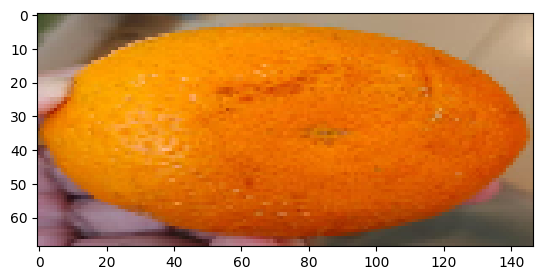

In [197]:
# Place detected bounding boxes on the image
from PIL import Image
from PIL import ImageDraw

def draw_bounding_boxes_on_image(image, boxes, classes, scores, max_boxes=1, min_score=0.1):
    image_width, image_height = image.size
    draw = ImageDraw.Draw(image)
    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            (left, right, top, bottom) = (xmin * image_width, xmax * image_width,
                                          ymin * image_height, ymax * image_height)
            draw.line([(left, top), (left, bottom), (right, bottom),
                       (right, top), (left, top)], width=1, fill='red')
            text = "{}: {:.2f}".format(classes[i], scores[i])
            draw.text((left, top), text, fill='red')

    return image

# Draw the bounding boxes on the image

image_with_boxes = draw_bounding_boxes_on_image(Image.fromarray(img_array[0].astype(np.uint8)),
                                                detector_output['detection_boxes'][0].numpy(),
                                                detector_output['detection_classes'][0].numpy().astype(int),
                                                detector_output['detection_scores'][0].numpy())

# crop images
from PIL import Image

def crop_image(image, boxes):
    image_width, image_height = image.size
    cropped_images = []
    for i in range(boxes.shape[0]):
        ymin, xmin, ymax, xmax = tuple(boxes[i])
        (left, right, top, bottom) = (xmin * image_width, xmax * image_width,
                                      ymin * image_height, ymax * image_height)
        cropped_images.append(image.crop((left, top, right, bottom)))

    return cropped_images[0]

# Crop the image
cropped_image = crop_image(Image.fromarray(img_array[0].astype(np.uint8)),
                           detector_output['detection_boxes'][0].numpy())

# Display the cropped image
plt.imshow(cropped_image)

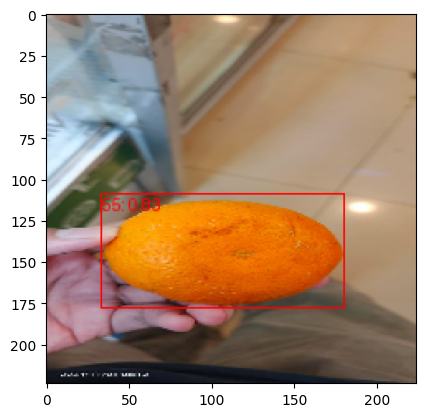

In [198]:
# Display the image with bounding boxes
plt.imshow(image_with_boxes)

In [199]:
# Predict cropped image
cropped_image = cropped_image.resize((224, 224))
cropped_image = image.img_to_array(cropped_image)
cropped_image = np.expand_dims(cropped_image, axis=0)

predictions = model.predict(cropped_image)
print('Fresh : ', predictions[0][0].astype(float))
print('Stale : ', predictions[0][1].astype(float))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Fresh :  0.4700528681278229
Stale :  0.5299471020698547
